In [1]:
import numpy as np
from PIL import Image as pil
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

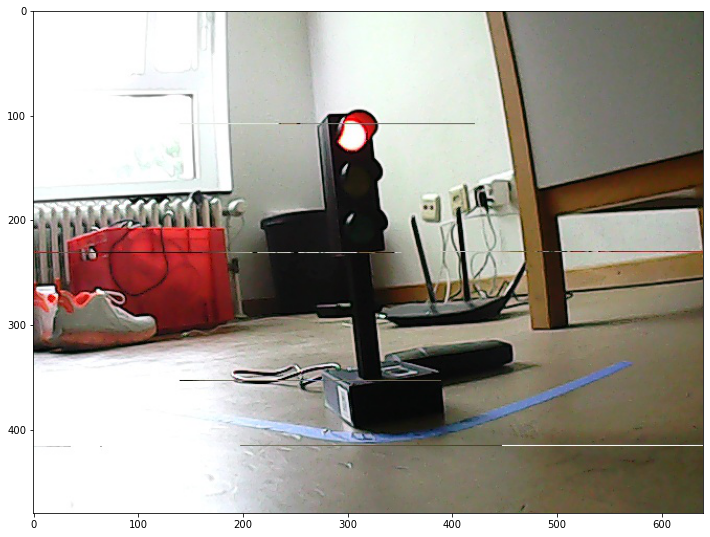

In [31]:
# Checking out picture
def display_img(img,cmap=None):
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(111)
    ax.imshow(img,cmap)

img = cv2.imread("Assets/Stop_light_color/Red/2022_5_27_18_53_25.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
display_img(img)

In [32]:
# Checking out the size of the images
desired_size = 300
desired_shape = desired_size, desired_size

print(f'Current image shape: {img.shape}')
print(f'Desired image shape: {desired_shape}')

source_folder = './Assets/Stop_light_color/Processed/'

count = 0
# goes through all folders
for root, dirs, files in os.walk(source_folder):
    # for each folder: goes through each file
    for pic in files:
        #loads image
        img_path = os.path.join(root, pic)
        img = pil.open(img_path)
        #width, height = img.size
        #if width > height:
        #    left = int((width-height)/2)
            # insert the crop method here!
        #    img = img.crop((0+left, 0, width-left, height))    
        #else:
        #    upper = int((height-width)/2)
            # insert the crop method here!
        #    img = img.crop((0, 0+upper, width, height-upper))

        # this code resizes the cropped image and overwrites the file with the transformed image.
        img = img.resize(desired_shape, pil.ANTIALIAS)
        img.save(os.path.join(root, pic))
        count += 1
        
print(f'{count} images done')

Current image shape: (480, 640, 3)
Desired image shape: (300, 300)
858 images done


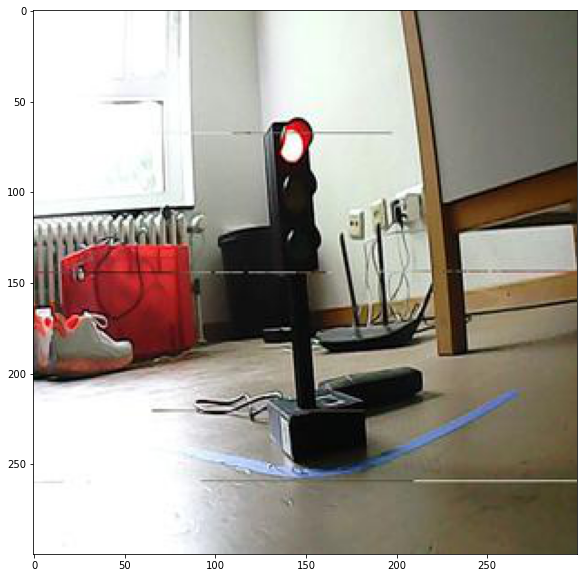

In [33]:
# Checking out pictures have the expected shape
img = cv2.imread("Assets/Stop_light_color/Processed/Red/2022_5_27_18_53_25.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
display_img(img)

In [34]:
import random
import shutil

# Splitting into train and test set
source_folder = './Assets/Stop_light_color/Processed/'
labels = ['Red', 'Yellow', 'Green', 'None']

for label in labels:
    filenames = os.listdir(source_folder + label)
    random.shuffle(filenames)
    
    # 80% of the data will be for training and 20% for testing
    split_index = int(len(filenames)*0.8) 
    
    train_folder = source_folder + 'train/' + label
    test_folder = source_folder + 'test/' + label
    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)
    
    for i,file in enumerate(filenames):
        if '.ipynb' in file:
            continue
        elif i < split_index:
            shutil.move(source_folder + label + f'/{file}', train_folder)
        else:
            shutil.move(source_folder + label + f'/{file}', test_folder)
            
# delete old dirs if your are certain that everything works :)
for i in range(2):
    shutil.rmtree(source_folder + labels[i])
    
# what's the result?
for folder in os.walk(source_folder):
    print("folder: {}, file count: {}".format(folder[0], len(folder[2])))

folder: ./Assets/Stop_light_color/Processed/, file count: 0
folder: ./Assets/Stop_light_color/Processed/Green, file count: 0
folder: ./Assets/Stop_light_color/Processed/None, file count: 0
folder: ./Assets/Stop_light_color/Processed/test, file count: 0
folder: ./Assets/Stop_light_color/Processed/test\Green, file count: 46
folder: ./Assets/Stop_light_color/Processed/test\None, file count: 20
folder: ./Assets/Stop_light_color/Processed/test\Red, file count: 51
folder: ./Assets/Stop_light_color/Processed/test\Yellow, file count: 56
folder: ./Assets/Stop_light_color/Processed/train, file count: 0
folder: ./Assets/Stop_light_color/Processed/train\Green, file count: 184
folder: ./Assets/Stop_light_color/Processed/train\None, file count: 76
folder: ./Assets/Stop_light_color/Processed/train\Red, file count: 204
folder: ./Assets/Stop_light_color/Processed/train\Yellow, file count: 221


In [38]:
# Expanding the data
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

batch_size = 16

image_gen = ImageDataGenerator(rotation_range=30, # rotate the image 30 degrees
                               width_shift_range=0.1, # Shift the pic width by a max of 10%
                               height_shift_range=0.1, # Shift the pic height by a max of 10%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.2, # Shear means cutting away part of the image (max 20%)
                               zoom_range=0.2, # Zoom in by 20% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest') # Fill in missing pixels with the nearest filled value

train_generator = image_gen.flow_from_directory(source_folder + 'train/', batch_size=batch_size, target_size=desired_shape, class_mode='categorical')
test_generator = image_gen.flow_from_directory(source_folder + 'test/', batch_size=batch_size, target_size=desired_shape, class_mode='categorical')


Found 685 images belonging to 4 classes.
Found 173 images belonging to 4 classes.


In [39]:
# Creating our model
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Activation, Flatten, Dropout
from tensorflow import keras

desired_size = 300

if keras.backend.image_data_format() == 'channels_first':
    input_shape = (3, desired_size, desired_size)
else:
    input_shape = (desired_size, desired_size, 3)

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=input_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(4))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 298, 298, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 149, 149, 32)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 147, 147, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 73, 73, 64)       0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 341056)            0         
                                                                 
 dense_8 (Dense)             (None, 128)              

In [40]:
# Training the model 
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)
checkpointer = ModelCheckpoint(filepath='stopLightColorCNN.hdf5', verbose = 1, save_best_only=True)

model.fit(train_generator, epochs=500, steps_per_epoch=len(train_generator), validation_data=test_generator, callbacks=[early_stop, checkpointer])

Epoch 1/500
43/43 [==============================] - ETA: 0s - loss: 2.3565 - accuracy: 0.2934
Epoch 1: val_loss improved from inf to 1.37004, saving model to stopLightColorCNN.hdf5
43/43 [==============================] - 64s 1s/step - loss: 2.3565 - accuracy: 0.2934 - val_loss: 1.3700 - val_accuracy: 0.2948
Epoch 2/500
43/43 [==============================] - ETA: 0s - loss: 1.3612 - accuracy: 0.3255
Epoch 2: val_loss improved from 1.37004 to 1.34891, saving model to stopLightColorCNN.hdf5
43/43 [==============================] - 56s 1s/step - loss: 1.3612 - accuracy: 0.3255 - val_loss: 1.3489 - val_accuracy: 0.3237
Epoch 3/500
43/43 [==============================] - ETA: 0s - loss: 1.3641 - accuracy: 0.3328
Epoch 3: val_loss did not improve from 1.34891
43/43 [==============================] - 51s 1s/step - loss: 1.3641 - accuracy: 0.3328 - val_loss: 1.3500 - val_accuracy: 0.3121
Epoch 4/500
43/43 [==============================] - ETA: 0s - loss: 1.3438 - accuracy: 0.3241
Epoch 4:

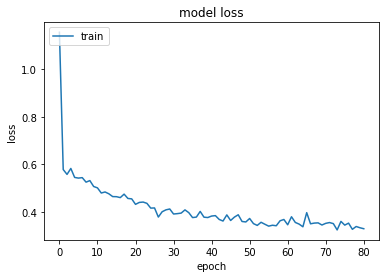

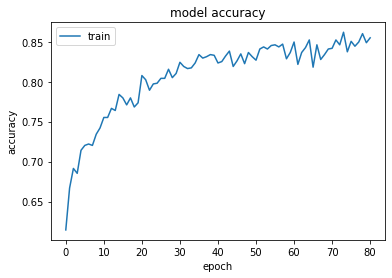

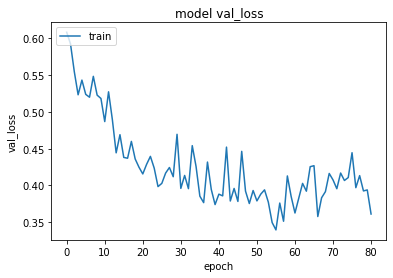

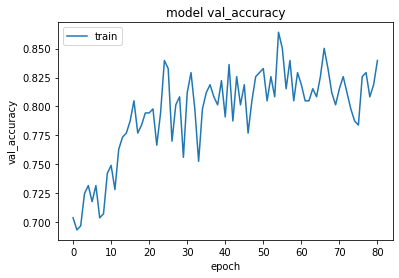

In [22]:
from matplotlib import pyplot as plt

# Progress of metrics
for key in model.history.history.keys():
    plt.plot(model.history.history[key])
    plt.title('model '+key)
    plt.ylabel(key)
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()

In [74]:
from keras.preprocessing import image

file = 'Assets/Stop_light/Processed/test/Negative/2022_5_27_20_23_54.jpg'

img = image.load_img(file, target_size=(desired_size, desired_size))

img = image.img_to_array(img)

img = np.expand_dims(img, axis=0)
img = img/255

In [75]:
prediction_prob = model.predict(img)
print(f'Probability that image is stop light is: {prediction_prob} ')

Probability that image is stop light is: [[0.13895833]] 
